# Week 15 Forecast. December 7, 2020
## Lourdes Fierro. Google colab try! 

1. First step is to install mododules

In [24]:
!pip install numpy
!pip install pandas
!pip install nwis
!pip install DateTime
!pip install matplotlib
!pip install scikit-learn
!pip install urllib3
!pip install contextily
!pip install Shapely
!pip install geopandas
!pip install Fiona
!pip install dataretrieval==0.1
!pip install rioxarray

In [25]:

import os
import math
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.datasets import fetch_california_housing
from sklearn import metrics
import json 
import urllib.request as req
import urllib
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import contextily as ctx
from shapely.geometry import Point
import geopandas as gpd
import fiona
import matplotlib as mpl
from netCDF4 import Dataset
import xarray as xr
import rioxarray
import geopandas as gpd
import fiona
import shapely
import time

2. Function section

In [26]:
def getstrm_wbs(station_id,end_date):
    """Get stream flow from 
    https://waterdata.usgs.gov/nwis/.
    ---------------------------------
    This function download streamflow. It needs 
    as input the station id number and the end date of data.
    Dataset start on 1989-01-01.
    ---------------------------------
    Parameters:
    station_id = list of string numbers
    end_date = string date as yyyy-mm-dd
    ----------------------------------
    Outputs:
    lastNames = dataframe with streamflow values and dates
    """
    start_date = '1989-01-01'
    flow_data = nwis.get_record(sites=station_id, service='dv',
                          start=start_date, end=end_date,
                          parameterCd='00060')
    flow_data.columns = ['flow', 'code', 'site_no']
    flow_data = flow_data.rename_axis("datetime")
    flow_data['datetime'] = pd.to_datetime(flow_data.index)
    return(flow_data)


def add_yymmdd(flow_data):
    """Add year,week,day columns to data 
    ---------------------------------
    This function adds year,week,day 
    colummns to data to facilitate computation
    ---------------------------------
    Parameters:
    data = dataframe data
    ----------------------------------
    Outputs:
    flow_data = dataframe with extra columns
    """

    #flow_data['datetime'] = pd.to_datetime(flow_data.index)
    flow_data['datetime'] = pd.to_datetime(flow_data.index)
    flow_data['year'] = pd.DatetimeIndex(flow_data.index).year
    flow_data['month'] = pd.DatetimeIndex(flow_data.index).month
    flow_data['day'] = pd.DatetimeIndex(flow_data.index).day
    flow_data['dayofweek'] = pd.DatetimeIndex(flow_data.index).dayofweek
    return(flow_data)


# Building a function for our Linear Regression Model
def mono_reg_mod(test_weeks):
    """Linear Regression Model data being offset only once.
    test weeks = natural log streamflow laged by 1 week (x values)
    test weeks = natural log streamflow (y values)
    """
    reg_model = LinearRegression()
    x_val_model1 = test_weeks['log_flow_tm1'].values.reshape(-1, 1)  # Testing values
    y_val_model1 = test_weeks['log_flow'].values  # Testing values
    reg_model.fit(x_val_model1, y_val_model1)  # Fit linear model
    coeff_det1 = np.round(reg_model.score(x_val_model1, y_val_model1), 7)  # r^2
    b = np.round(reg_model.intercept_, 7)  # Intercept
    m = np.round(reg_model.coef_, 7)  # Slope
    print('coefficient of determination:', np.round(coeff_det1, 7))
    # Intercept and the slope (Final equation) y= mx + b
    print('Final equation is y1 = :', m[:1], 'x + ', b)
    return(b,m,reg_model,coeff_det1)


# Building a function to produce our two week flow predictions
# using linaral model1 with only one data offsets
def flow_predic_mono(b, m, num_of_weeks, week_b4, forecast_weeks):
    """This function produces predicted flow values using coefficients provided
    by an Liner Autoregressive Model with only one data offset.
    'b' is the y-intersept and 'm' is the slope.
    'num_of_weeks' is how many weeks you would like to loop the model for.
    'week_b4' is the natural log flow of a known flow and
    'forecast_weeks' is a list of dates that you are predicting for.
    """
    week_b4_i = week_b4
    pred_i = np.zeros((num_of_weeks, 1))
    for i in range(1, num_of_weeks + 1):
            log_flow_pred_i = b + m[:1] * week_b4_i
            flow_pred_i = math.exp(log_flow_pred_i)
            pred_i[i-1] = flow_pred_i
            week_b4_i = log_flow_pred_i
    flow_predictions_lin = pd.DataFrame(pred_i, index = forecast_weeks,
                                        columns=["Predicted_Flows_Lin:"])
    return flow_predictions_lin


# Building a function to produce our two week flow predictions
def week_prediction_all(flow, m, b, week_pred, end, prev_wks):
    """This function needs the stream flow data (flow), the intersection
    and slope values from AR model (m, b), and range of weeks you want to
    consider for weekly forecast (prev_wks and end). To indicate the week
    to forecast include the week number (week_pred = 1 or week_pred = 2)
    We are using the mean value of the data range you select - the standard
    deviation of the same data range
    """
    Corr_fact1 = 0.2 # 0.25 dryest season
    no_weeks = flow['log_flow'].size
    #Corr_fact1 = 0.4*flow['log_flow'][no_weeks - prev_wks:no_weeks-end].std()
    #Corr_fact1 = flow['log_flow'][no_weeks-end] / flow['log_flow'][no_weeks-(end-1)]
    flow_range_value = flow['log_flow'][no_weeks-prev_wks:no_weeks-end].mean() -Corr_fact1*flow['log_flow'][no_weeks - prev_wks:no_weeks-end].std()
    prediction = math.exp((b + m * flow_range_value))*(1-Corr_fact1) # dryness of this year
    print('Week', week_pred, 'forecast using model is:', prediction,'Correction factor:',Corr_fact1)
    return prediction,Corr_fact1




3. Define variables that are constant

In [27]:
# %% Define trainning period
station_id = '09506000'  # Streamflow station
trainstart = '2016-01-01'  # Start date to train AR model
trainend = '2019-12-31'  # end date to train AR model
lag = 2  # No. of weeks to consider for lag 
end_date = '2020-12-05'  # yyyy-mm-dd (changes each week)
forecast_week_1_2 = ['2020-12-06','2020-12-13']

4. Download flow data

In [28]:
# %% Streamflow section
# Get streamflow from website using getstrm_wbs function

flow_data = getstrm_wbs(station_id,end_date)  # get strmflow data from website
flow_data_pd = add_yymmdd(flow_data)  # add year,month,day

flow_weekly = flow_data_pd.resample("W", on='datetime').mean()  # Add flow values to weekly
flow_weekly.insert(2, 'log_flow', np.log(flow_weekly['flow']), True)  # Natural log (fits the model better)


5. Training the model

In [29]:
# %% Step 1: setup the arrays (to build the model)
# Autoregressive model (based on the lagged timeserie)

shifts = list(range(1, lag+1))
flow_weekly['log_flow_tm1'] = flow_weekly['log_flow'].shift(shifts[0])  # Lag 1week
flow_weekly['log_flow_tm2'] = flow_weekly['log_flow'].shift(shifts[1])  # Lag 2weeks

# %% Step 2: Pick time series portion to train model
print('Start training week: ', trainstart)
print('End training week: ', trainend)

# Dropping first two weeks (won't have lagged data) to go with them
train = flow_weekly[trainstart:trainend][['log_flow',
                                          'log_flow_tm1', 'log_flow_tm2']]
test = flow_weekly[trainend:][['log_flow',
                               'log_flow_tm1', 'log_flow_tm2']]

# %% Step 2: Pick time series portion to train model
print('Start training week: ', trainstart)
print('End training week: ', trainend)

# Dropping first two weeks (won't have lagged data) to go with them
train = flow_weekly[trainstart:trainend][['log_flow',
                                          'log_flow_tm1', 'log_flow_tm2']]
test = flow_weekly[trainend:][['log_flow',
                               'log_flow_tm1', 'log_flow_tm2']]


# %% Step 3 Fit AR model (linear regression model using sklearn, 1 var)
b, m, reg_model1, coeff_det1 = mono_reg_mod(train)


Start training week:  2016-01-01
End training week:  2019-12-31
Start training week:  2016-01-01
End training week:  2019-12-31
coefficient of determination: 0.776843
Final equation is y1 = : [0.8851347] x +  0.5907568


6. Getting 2 weeks prediction

In [30]:
# %% Getting our two week predictions!
# Geting last weeks flow
week_before_flow = flow_weekly['log_flow'].tail(1)
print("Last weeks's flow was", math.exp(week_before_flow),'cfs!', '\n')

# Defining prediction weeks for our 2 week predic.
# These are the weeks we will be predicting for our 2 week predictions.
# forecast_week_1_2 = ['2020-11-09','2020-11-16']
print(flow_predic_mono(b, m, 2, week_before_flow, forecast_week_1_2), '\n')

Last weeks's flow was 158.83333333333337 cfs! 

            Predicted_Flows_Lin:
2020-12-06            160.210968
2020-12-13            161.440327 



7. Getting seasonal forecast

In [31]:
# %% 16 week forecast taking previous 12 weeks mean before week to forecast
no_weeks = flow_weekly['log_flow'].size  # Number of weeks up to date
begining_week_ly = 80  # start week year 2008 30 653
ending_week_ly = 63  # end week year 2008 12 640 66
dates_weeks_range = flow_weekly['log_flow'][no_weeks-begining_week_ly:
                                           no_weeks-ending_week_ly] 

wk_prd = np.zeros(16)
for i in range(1,17):
       wk_prd = week_prediction_all(flow=flow_weekly, m=m, b=b,
                                    prev_wks=begining_week_ly, end=ending_week_ly, week_pred=i)
       begining_week_ly = begining_week_ly+1
       ending_week_ly = ending_week_ly +1


Week 1 forecast using model is: 49.7920673056216 Correction factor: 0.2
Week 2 forecast using model is: 51.342202403252365 Correction factor: 0.2
Week 3 forecast using model is: 52.89059788167897 Correction factor: 0.2
Week 4 forecast using model is: 53.65020787365697 Correction factor: 0.2
Week 5 forecast using model is: 56.14770405228879 Correction factor: 0.2
Week 6 forecast using model is: 59.497763374143034 Correction factor: 0.2
Week 7 forecast using model is: 61.49509503258133 Correction factor: 0.2
Week 8 forecast using model is: 62.58541565931739 Correction factor: 0.2
Week 9 forecast using model is: 64.53365705756391 Correction factor: 0.2
Week 10 forecast using model is: 70.72538932270946 Correction factor: 0.2
Week 11 forecast using model is: 80.16090649956966 Correction factor: 0.2
Week 12 forecast using model is: 94.25948078156027 Correction factor: 0.2
Week 13 forecast using model is: 114.06090856149797 Correction factor: 0.2
Week 14 forecast using model is: 136.92219661

8. Plot

Method of flow quantiles for month               flow code   site_no   datetime  year  month  day  dayofweek
datetime                                                                
1989-08-01  146.0    A  09506000 1989-08-01  1989      8    1          1
1989-08-02  137.0    A  09506000 1989-08-02  1989      8    2          2
1989-08-03  130.0    A  09506000 1989-08-03  1989      8    3          3
1989-08-04  178.0    A  09506000 1989-08-04  1989      8    4          4
1989-08-05  196.0    A  09506000 1989-08-05  1989      8    5          5
...           ...  ...       ...        ...   ...    ...  ...        ...
2020-12-01  159.0    P  09506000 2020-12-01  2020     12    1          1
2020-12-02  157.0    P  09506000 2020-12-02  2020     12    2          2
2020-12-03  157.0    P  09506000 2020-12-03  2020     12    3          3
2020-12-04  159.0    P  09506000 2020-12-04  2020     12    4          4
2020-12-05  162.0    P  09506000 2020-12-05  2020     12    5          5

[4870 rows x 8

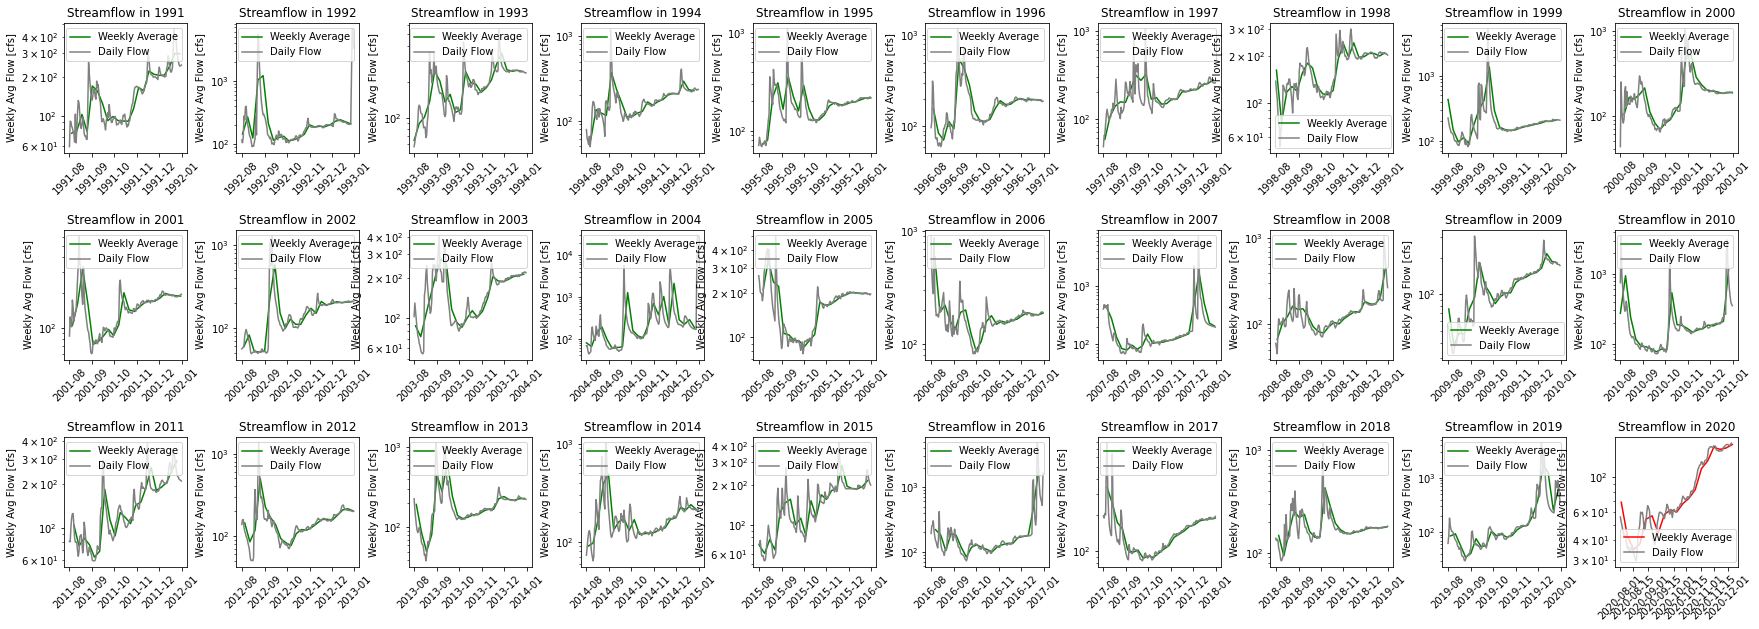

In [32]:
# %% Plot streamflow

# This is the final graph function, to adjust for naming differences, the only
# change needed is to the parts before the for loop and defining data_mnth_i &
# flow_weekly_mnth_i in the for loop
data_mnth = flow_data_pd[flow_data_pd['month'] > 7]
flow_weekly_mnth = flow_weekly[flow_weekly['month'] > 7]
flow_quants_mnth = np.quantile(flow_weekly_mnth['flow'], q=[0, 0.5, 0.75, 0.9])
print('Method of flow quantiles for month ', data_mnth, ':', flow_quants_mnth)
print('For plots, Green is flow max above 75%, and Red is below 50%')
fig = plt.figure(figsize=(30, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(1, 31):
    curr_yr = (i + 1990)
    flow_weekly_mnth_i = flow_weekly_mnth[flow_weekly_mnth['year'] ==
                                          curr_yr]
    data_mnth_i = data_mnth[data_mnth['year'] == curr_yr]
    ax = fig.add_subplot(3, 10, i)
    ax.set(title=("Streamflow in " + str(curr_yr)),
           ylabel="Weekly Avg Flow [cfs]", yscale='log')
    plt.xticks(rotation=45)
    if (np.max(flow_weekly_mnth_i['flow']) > flow_quants_mnth[2]):
        ax.plot(flow_weekly_mnth_i['flow'],
                '-g', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey',
                label='Daily Flow')
        ax.legend()
    elif (np.max(flow_weekly_mnth_i['flow']) < flow_quants_mnth[1]):
        ax.plot(flow_weekly_mnth_i['flow'],
                '-r', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey',
                label='Daily Flow')
        ax.legend()
    else:
        ax.plot(flow_weekly_mnth_i['flow'],
                '-b', label='Weekly Average')
        ax.plot(data_mnth_i['datetime'], data_mnth_i['flow'], color='grey', 
                label='Daily Flow')
        ax.legend()